In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from arc import *
from time import time
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from typing import List, Dict
import gc

from basics import *
from utility import *
from floquet_hamiltonian import *


pi=np.pi
tau=2*pi

In [2]:
# Initialize to None when computational paramters are changed. Lets downstream program know when to re-build basis
basis = None
levels = None
basis_n = None

energies = None
eigenstates = None

# Computational Parameters
scheme = ["red", "mid", "low"][0]

if scheme == "low":
    t_level = RydStateFS(52,1,1/2)
else:
    t_level = RydStateFS(52,1,3/2)
    
max_det = tau*40e9  # radians/s
dl = 2
n_max = 2
single_side = False  # True currently breaks code. Issue in utility.level_starts() function.

comp = {
    "max_det": max_det,
    "dl": dl,
    "n_max": n_max
}

zeeman_offset = 1e4 if scheme == "red" else 1e2

results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
convergence_tests_dir = r"Shirley-Floquet_results/convergence_tests/"
plots_dir =  r"Shirley-Floquet_results\PolarizabilityPlots"
zfigs_dir = r"Z:\Public\Hybrid\Publications\Dressing in Cryostat\figures_TODO"

In [3]:
comp_settings_list = {
    "default": {
        "max_det": tau*40e9,
        "dl": 2,
        "n_max": 2
    },
    "dipoles": {
        "max_det": tau*40e9,
        "dl": 1,
        "n_max": 2
    },
    "more_energy": {
        "max_det": tau*80e9,
        "dl": 2,
        "n_max": 2
    },
    "more_photons": {
        "max_det": tau*40e9,
        "dl": 2,
        "n_max": 3
    }   
}

fields = {
    "Eac": 89.6,  # band 4 nulling condition
    "ellipticity": 0.012,
    "field_omega": tau*4.780e9,
    "Edc": 0,
    "theta": 0
}

Eac_list = np.append(np.linspace(0,15,200),np.linspace(15+75/300,90,350))
Edc_list = np.linspace(0,15,100)


# measured resonance between nP3/2 -> (n-1)D3/2 levels
p3o2_d3o2_res = 4839*1e6*tau
laser_dAC = detuning(RydStateFS(51,2,3/2), t_level, p3o2_d3o2_res)

# Set computational settings here

In [116]:
comp_name = "more_energy"
comp = comp_settings_list[comp_name]
basis=None
basis_n = None

## Build Basis

In [117]:
try:
    energies = None
    eigenstates = None
except NameError:
    pass
if basis is None or levels is None:
    levels, basis = build_basis(t_level,single_side=single_side, dl=comp["dl"],max_det=comp["max_det"])
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    t_states = [basis[i] for i in t_inds]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max=comp["n_max"])
print(len(basis),len(basis_n))
basis_print(levels)
basis_print(basis_n)
len(basis_n)

80 400
[
	|51,P,1/2>,
	|51,P,3/2>,
	|50,D,3/2>,
	|50,D,5/2>,
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>,
	|53,P,1/2>,
	|53,P,3/2>,
	|52,D,3/2>,
	|52,D,5/2>
]
[
	|51,P,1/2;mj:-1/2,nphot:-2>,
	|51,P,1/2;mj:1/2,nphot:-2>,
	|51,P,3/2;mj:-3/2,nphot:-2>,
	|51,P,3/2;mj:-1/2,nphot:-2>,
	|51,P,3/2;mj:1/2,nphot:-2>,
	|51,P,3/2;mj:3/2,nphot:-2>,
	|50,D,3/2;mj:-3/2,nphot:-2>,
	|50,D,3/2;mj:-1/2,nphot:-2>,
	|50,D,3/2;mj:1/2,nphot:-2>,
	|50,D,3/2;mj:3/2,nphot:-2>,
	|50,D,5/2;mj:-5/2,nphot:-2>,
	|50,D,5/2;mj:-3/2,nphot:-2>,
	|50,D,5/2;mj:-1/2,nphot:-2>,
	|50,D,5/2;mj:1/2,nphot:-2>,
	|50,D,5/2;mj:3/2,nphot:-2>,
	|50,D,5/2;mj:5/2,nphot:-2>,
	|52,S,1/2;mj:-1/2,nphot:-2>,
	|52,S,1/2;mj:1/2,nphot:-2>,
	|48,F,5/2;mj:-5/2,nphot:-2>,
	|48,F,5/2;mj:-3/2,nphot:-2>,
	|48,F,5/2;mj:-1/2,nphot:-2>,
	|48,F,5/2;mj:1/2,nphot:-2>,
	|48,F,5/2;mj:3/2,nphot:-2>,
	|48,F,5/2;mj:5/2,nphot:-2>,
	|48,F,7/2;mj:-7/2,nphot:-2>,
	|48,F,7/2;mj:-5

400

In [8]:
for comp_name in comp_names:
    comp = comp_settings_list[comp_name]
    basis=None
    basis_n = None

    try:
        energies = None
        eigenstates = None
    except NameError:
        pass
    if basis is None or levels is None:
        levels, basis = build_basis(t_level,single_side=single_side, dl=comp["dl"],max_det=comp["max_det"])
        t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
        t_states = [basis[i] for i in t_inds]
    if basis_n is None:
        basis_n = build_n_basis(basis, n_max=comp["n_max"])
    print(len(basis),len(basis_n))
    basis_print(levels)
    basis_print(basis_n)
    len(basis_n)

    np.save(os.path.join(convergence_tests_dir,f"tinds_{comp_name}.npy"),np.array(t_inds))

KeyboardInterrupt: 

In [157]:
for comp_name in comp_names:
    t_ind_load = np.load(os.path.join(convergence_tests_dir,f"tinds_{comp_name}.npy"))
    print(comp_name+f"\n\tt_inds={t_ind_load}")

default
	t_inds=[18 19 20 21]
dipoles
	t_inds=[4 5 6 7]
more_energy
	t_inds=[34 35 36 37]
more_photons
	t_inds=[18 19 20 21]


## Scan Eac

In [93]:
# set scan params
varied = ("Eac",Eac_list)
fields_p = {key: value for key, value in fields.items()}
fields_p[varied[0]] = varied[1]

#old_scans = eigen_find(t_level,comp, fields_p)
#loading = False
# TODO : this is broken rn. Implement eigen_terpolate then fix this.
#if loading and len(old_scans) > 0: 
#    energies = np.load(old_scans[0][0].format("energies"))
#    eigenstates = np.load(old_scans[0][0].format("eigenstates"))
#else:
zeeman_offset=1e6
H0 = build_H0(basis, t_level, offset_zeeman=zeeman_offset)
if scheme == "red":
    H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 3]
f_jsplit = 3e6
jsplit = True
if jsplit:
    for ind, j in f_inds:
        H0[ind,ind] += f_jsplit*j
    
energies, eigenstates, error = floquet_loop(
    basis,
    H0,
    n_max=comp["n_max"],
    varied=varied,
    energy_bands=True,
    **fields
)

#f_name = f"convergenceTest-nmax={n_max}-dw={max_det}-dl={dl}-{{}}"
#filepath = "Shirley-Floquet_results\\convergence_tests"
#np.save(os.path.join(filepath,f_name.format("energies")), energies)
#np.save(os.path.join(filepath,f_name.format("eigenstates")), eigenstates)
#eigen_save(t_level, comp, fields_p, energies, eigenstates)

336
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008003711700439453
Hdc built in 0.0010039806365966797
Hfloquet put together in 0.0012006759643554688
Floquet matrix built after 0.010208368301391602 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 0.0, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.013504981994628906s
Normalization Complete after 0.003999471664428711 s
floquet_diag call completed in 0.02771282196044922s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>


Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 0.5276381909547738, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.31593871116638184s
Normalization Complete after 0.0029969215393066406 s
floquet_diag call completed in 0.3304429054260254s
Diagonalization complete for independent variable entry, value 7, 0.5276381909547738
re-arrangement done after time 0.009459972381591797s
little_d built in 0.008508682250976562
Hdc built in 0.0010025501251220703
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.010511159896850586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 0.6030150753768844, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3211851119995117s
Normalization Complete after 0.004001140594482422 s
floquet_diag call completed in 0.33620333671569824s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 1.507537688442211, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32134127616882324s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.337338924407959s
Diagonalization complete for independent variable entry, value 20, 1.507537688442211
re-arrangement done after time 0.010517120361328125s
little_d built in 0.008530139923095703
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0010039806365966797
Floquet matrix built after 0.01053476333618164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 1.5829145728643215, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3231523036956787s
Normalization Complete after 0.002999544143676758 s
floquet_diag call completed in 0.33768677711486816s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 2.487437185929648, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.31995248794555664s
Normalization Complete after 0.002997159957885742 s
floquet_diag call completed in 0.335463285446167s
Diagonalization complete for independent variable entry, value 33, 2.487437185929648
re-arrangement done after time 0.00952005386352539s
little_d built in 0.009504079818725586
Hdc built in 0.0010035037994384766
Hfloquet put together in 0.0
Floquet matrix built after 0.010507583618164062 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 2.5628140703517586, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3175797462463379s
Normalization Complete after 0.004000663757324219 s
floquet_diag call completed in 0.33208799362182617s
Diagonalization complete for independent variable entry, value 34, 2

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 3.467336683417085, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32210659980773926s
Normalization Complete after 0.0035185813903808594 s
floquet_diag call completed in 0.3381688594818115s
Diagonalization complete for independent variable entry, value 46, 3.467336683417085
re-arrangement done after time 0.010510921478271484s
little_d built in 0.009510517120361328
Hdc built in 0.0010094642639160156
Hfloquet put together in 0.000993490219116211
Floquet matrix built after 0.011513471603393555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 3.5427135678391957, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3207247257232666s
Normalization Complete after 0.0030045509338378906 s
floquet_diag call completed in 0.3362424373626709s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 4.447236180904522, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32135963439941406s
Normalization Complete after 0.0035042762756347656 s
floquet_diag call completed in 0.33692359924316406s
Diagonalization complete for independent variable entry, value 59, 4.447236180904522
re-arrangement done after time 0.00958108901977539s
little_d built in 0.009005069732666016
Hdc built in 0.0
Hfloquet put together in 0.0020072460174560547
Floquet matrix built after 0.01151895523071289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 4.522613065326633, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3176085948944092s
Normalization Complete after 0.00400543212890625 s
floquet_diag call completed in 0.3331329822540283s
Diagonalization complete for independent variable entry, value 60, 4.

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 5.427135678391959, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3119208812713623s
Normalization Complete after 0.0035092830657958984 s
floquet_diag call completed in 0.32794833183288574s
Diagonalization complete for independent variable entry, value 72, 5.427135678391959
re-arrangement done after time 0.009518146514892578s
little_d built in 0.00951075553894043
Hdc built in 0.0007758140563964844
Hfloquet put together in 0.001041412353515625
Floquet matrix built after 0.011327981948852539 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 5.50251256281407, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3171200752258301s
Normalization Complete after 0.002999544143676758 s
floquet_diag call completed in 0.33244776725769043s
Diagonalization complete for independent variable e

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 6.407035175879397, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32538390159606934s
Normalization Complete after 0.0039997100830078125 s
floquet_diag call completed in 0.3408949375152588s
Diagonalization complete for independent variable entry, value 85, 6.407035175879397
re-arrangement done after time 0.009514808654785156s
little_d built in 0.010025262832641602
Hdc built in 0.0009975433349609375
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.012023210525512695 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 6.482412060301507, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3287515640258789s
Normalization Complete after 0.0040013790130615234 s
floquet_diag call completed in 0.34528040885925293s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 7.3869346733668335, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3208165168762207s
Normalization Complete after 0.004511594772338867 s
floquet_diag call completed in 0.3379189968109131s
Diagonalization complete for independent variable entry, value 98, 7.3869346733668335
re-arrangement done after time 0.010633230209350586s
little_d built in 0.008512496948242188
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011518239974975586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 7.462311557788944, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3185272216796875s
Normalization Complete after 0.004000425338745117 s
floquet_diag call completed in 0.3350489139556885s
Diagonalization complete for independent variable entry, value 99, 7.462311557788944


Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 8.36683417085427, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3126096725463867s
Normalization Complete after 0.002997875213623047 s
floquet_diag call completed in 0.3282589912414551s
Diagonalization complete for independent variable entry, value 111, 8.36683417085427
re-arrangement done after time 0.009931802749633789s
little_d built in 0.008184194564819336
Hdc built in 0.0
Hfloquet put together in 0.0010039806365966797
Floquet matrix built after 0.011702775955200195 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 8.442211055276381, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32567286491394043s
Normalization Complete after 0.0035102367401123047 s
floquet_diag call completed in 0.34189414978027344s
Diagonalization complete for independent variable entry, value 112,

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 9.346733668341708, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3371098041534424s
Normalization Complete after 0.003996610641479492 s
floquet_diag call completed in 0.35161781311035156s
Diagonalization complete for independent variable entry, value 124, 9.346733668341708
re-arrangement done after time 0.010541677474975586s
little_d built in 0.00850057601928711
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.011507511138916016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 9.422110552763819, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32944440841674805s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.344951868057251s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 10.326633165829145, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3581867218017578s
Normalization Complete after 0.00302886962890625 s
floquet_diag call completed in 0.3737983703613281s
Diagonalization complete for independent variable entry, value 137, 10.326633165829145
re-arrangement done after time 0.009521484375s
little_d built in 0.009513378143310547
Hdc built in 0.0
Hfloquet put together in 0.0009992122650146484
Floquet matrix built after 0.012516498565673828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 10.402010050251256, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.35077428817749023s
Normalization Complete after 0.004064798355102539 s
floquet_diag call completed in 0.3673555850982666s
Diagonalization complete for independent variable entry, value 138, 10.

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 11.306532663316581, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.326904296875s
Normalization Complete after 0.0039980411529541016 s
floquet_diag call completed in 0.3429582118988037s
Diagonalization complete for independent variable entry, value 150, 11.306532663316581
re-arrangement done after time 0.011049985885620117s
little_d built in 0.00915980339050293
Hdc built in 0.0009980201721191406
Hfloquet put together in 0.0004360675811767578
Floquet matrix built after 0.012289762496948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 11.381909547738692, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3208749294281006s
Normalization Complete after 0.0039997100830078125 s
floquet_diag call completed in 0.3381645679473877s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 12.286432160804019, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3233647346496582s
Normalization Complete after 0.004005908966064453 s
floquet_diag call completed in 0.3393583297729492s
Diagonalization complete for independent variable entry, value 163, 12.286432160804019
re-arrangement done after time 0.00932621955871582s
little_d built in 0.00951242446899414
Hdc built in 0.0010030269622802734
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.01151585578918457 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 12.36180904522613, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32188892364501953s
Normalization Complete after 0.0030059814453125 s
floquet_diag call completed in 0.33741164207458496s
Diagonalization complete for independent variable e

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 13.266331658291456, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3218576908111572s
Normalization Complete after 0.003026723861694336 s
floquet_diag call completed in 0.33739495277404785s
Diagonalization complete for independent variable entry, value 176, 13.266331658291456
re-arrangement done after time 0.010443925857543945s
little_d built in 0.009508371353149414
Hdc built in 0.0013575553894042969
Hfloquet put together in 0.0010378360748291016
Floquet matrix built after 0.011903762817382812 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 13.341708542713567, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.31761884689331055s
Normalization Complete after 0.0030019283294677734 s
floquet_diag call completed in 0.3335254192352295s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 14.246231155778894, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3342878818511963s
Normalization Complete after 0.0044596195220947266 s
floquet_diag call completed in 0.35092616081237793s
Diagonalization complete for independent variable entry, value 189, 14.246231155778894
re-arrangement done after time 0.010336875915527344s
little_d built in 0.009279727935791016
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0010025501251220703
Floquet matrix built after 0.012283563613891602 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 14.321608040201003, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3163943290710449s
Normalization Complete after 0.004001617431640625 s
floquet_diag call completed in 0.33267951011657715s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 15.678366762177651, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.323014497756958s
Normalization Complete after 0.0029990673065185547 s
floquet_diag call completed in 0.3385922908782959s
Diagonalization complete for independent variable entry, value 202, 15.678366762177651
re-arrangement done after time 0.011023998260498047s
little_d built in 0.008997440338134766
Hdc built in 0.001087188720703125
Hfloquet put together in 0.0010361671447753906
Floquet matrix built after 0.011120796203613281 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 15.892550143266476, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3315103054046631s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.3466310501098633s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 18.46275071633238, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3244938850402832s
Normalization Complete after 0.004093647003173828 s
floquet_diag call completed in 0.3399643898010254s
Diagonalization complete for independent variable entry, value 215, 18.46275071633238
re-arrangement done after time 0.00951242446899414s
little_d built in 0.009512901306152344
Hdc built in 0.000997781753540039
Hfloquet put together in 0.0010044574737548828
Floquet matrix built after 0.011515140533447266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 18.676934097421203, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32653188705444336s
Normalization Complete after 0.0040454864501953125 s
floquet_diag call completed in 0.34209251403808594s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 21.247134670487107, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32002997398376465s
Normalization Complete after 0.0035135746002197266 s
floquet_diag call completed in 0.3350558280944824s
Diagonalization complete for independent variable entry, value 228, 21.247134670487107
re-arrangement done after time 0.010523319244384766s
little_d built in 0.009505987167358398
Hdc built in 0.0010013580322265625
Hfloquet put together in 0.0010013580322265625
Floquet matrix built after 0.011508703231811523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 21.46131805157593, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33149266242980957s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.347001314163208s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 24.031518624641834, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33131909370422363s
Normalization Complete after 0.002998828887939453 s
floquet_diag call completed in 0.3469126224517822s
Diagonalization complete for independent variable entry, value 241, 24.031518624641834
re-arrangement done after time 0.00951075553894043s
little_d built in 0.009509801864624023
Hdc built in 0.0
Hfloquet put together in 0.0010001659393310547
Floquet matrix built after 0.011511564254760742 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 24.245702005730656, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33498311042785645s
Normalization Complete after 0.0029997825622558594 s
floquet_diag call completed in 0.35049962997436523s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 26.81590257879656, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3305814266204834s
Normalization Complete after 0.003509044647216797 s
floquet_diag call completed in 0.34670472145080566s
Diagonalization complete for independent variable entry, value 254, 26.81590257879656
re-arrangement done after time 0.01050877571105957s
little_d built in 0.009019136428833008
Hdc built in 0.0010058879852294922
Hfloquet put together in 0.0010006427764892578
Floquet matrix built after 0.011025667190551758 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 27.030085959885387, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3174736499786377s
Normalization Complete after 0.004005908966064453 s
floquet_diag call completed in 0.33350396156311035s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 29.600286532951287, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3299751281738281s
Normalization Complete after 0.004023075103759766 s
floquet_diag call completed in 0.34651732444763184s
Diagonalization complete for independent variable entry, value 267, 29.600286532951287
re-arrangement done after time 0.009511947631835938s
little_d built in 0.009511947631835938
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0010013580322265625
Floquet matrix built after 0.011512994766235352 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 29.814469914040114, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3337976932525635s
Normalization Complete after 0.0035092830657958984 s
floquet_diag call completed in 0.3498215675354004s
Diagonalization complete for independent vari

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 32.38467048710602, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33055567741394043s
Normalization Complete after 0.004522800445556641 s
floquet_diag call completed in 0.34659314155578613s
Diagonalization complete for independent variable entry, value 280, 32.38467048710602
re-arrangement done after time 0.010009288787841797s
little_d built in 0.008077859878540039
Hdc built in 0.0009989738464355469
Hfloquet put together in 0.0010018348693847656
Floquet matrix built after 0.011079072952270508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 32.59885386819484, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3198673725128174s
Normalization Complete after 0.0039997100830078125 s
floquet_diag call completed in 0.3349461555480957s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 35.16905444126074, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.35422253608703613s
Normalization Complete after 0.004000425338745117 s
floquet_diag call completed in 0.37174177169799805s
Diagonalization complete for independent variable entry, value 293, 35.16905444126074
re-arrangement done after time 0.009512186050415039s
little_d built in 0.009602546691894531
Hdc built in 0.0
Hfloquet put together in 0.0019960403442382812
Floquet matrix built after 0.01259922981262207 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 35.38323782234957, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33747315406799316s
Normalization Complete after 0.004510641098022461 s
floquet_diag call completed in 0.3545830249786377s
Diagonalization complete for independent variable entry, value 294

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 37.953438395415475, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3314838409423828s
Normalization Complete after 0.004509449005126953 s
floquet_diag call completed in 0.3482332229614258s
Diagonalization complete for independent variable entry, value 306, 37.953438395415475
re-arrangement done after time 0.009514808654785156s
little_d built in 0.009511232376098633
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.011509180068969727 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 38.1676217765043, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33385801315307617s
Normalization Complete after 0.004513978958129883 s
floquet_diag call completed in 0.3498811721801758s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 40.737822349570195, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3396477699279785s
Normalization Complete after 0.0050013065338134766 s
floquet_diag call completed in 0.3561570644378662s
Diagonalization complete for independent variable entry, value 319, 40.737822349570195
re-arrangement done after time 0.009515047073364258s
little_d built in 0.010511636734008789
Hdc built in 0.0
Hfloquet put together in 0.0010077953338623047
Floquet matrix built after 0.013025522232055664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 40.952005730659025, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3239169120788574s
Normalization Complete after 0.0040018558502197266 s
floquet_diag call completed in 0.3409442901611328s
Diagonalization complete for independent variable entry, value 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 43.52220630372493, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3210272789001465s
Normalization Complete after 0.003515481948852539 s
floquet_diag call completed in 0.3370506763458252s
Diagonalization complete for independent variable entry, value 332, 43.52220630372493
re-arrangement done after time 0.009044885635375977s
little_d built in 0.009508848190307617
Hdc built in 0.0010051727294921875
Hfloquet put together in 0.0010025501251220703
Floquet matrix built after 0.011516571044921875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 43.73638968481375, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32918477058410645s
Normalization Complete after 0.003999233245849609 s
floquet_diag call completed in 0.3457038402557373s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 46.306590257879655, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3295559883117676s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.34657883644104004s
Diagonalization complete for independent variable entry, value 345, 46.306590257879655
re-arrangement done after time 0.010521650314331055s
little_d built in 0.009508848190307617
Hdc built in 0.0
Hfloquet put together in 0.0010020732879638672
Floquet matrix built after 0.012511491775512695 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 46.52077363896848, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3325772285461426s
Normalization Complete after 0.004000186920166016 s
floquet_diag call completed in 0.3490889072418213s
Diagonalization complete for independent variable entry, value 34

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 49.09097421203438, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33487963676452637s
Normalization Complete after 0.00400090217590332 s
floquet_diag call completed in 0.35128164291381836s
Diagonalization complete for independent variable entry, value 358, 49.09097421203438
re-arrangement done after time 0.009212970733642578s
little_d built in 0.011084556579589844
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.013084888458251953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 49.305157593123205, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3368508815765381s
Normalization Complete after 0.0035126209259033203 s
floquet_diag call completed in 0.35445261001586914s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 51.87535816618911, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33652186393737793s
Normalization Complete after 0.004000425338745117 s
floquet_diag call completed in 0.3510291576385498s
Diagonalization complete for independent variable entry, value 371, 51.87535816618911
re-arrangement done after time 0.009513139724731445s
little_d built in 0.009505987167358398
Hdc built in 0.001001119613647461
Hfloquet put together in 0.0010020732879638672
Floquet matrix built after 0.012509822845458984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 52.08954154727793, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32770729064941406s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.3447742462158203s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 54.659742120343836, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3457612991333008s
Normalization Complete after 0.004101753234863281 s
floquet_diag call completed in 0.3613753318786621s
Diagonalization complete for independent variable entry, value 384, 54.659742120343836
re-arrangement done after time 0.009515047073364258s
little_d built in 0.009510993957519531
Hdc built in 0.001003265380859375
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.01151132583618164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 54.873925501432666, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3307063579559326s
Normalization Complete after 0.0035059452056884766 s
floquet_diag call completed in 0.3467295169830322s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 57.44412607449856, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.31867027282714844s
Normalization Complete after 0.003509998321533203 s
floquet_diag call completed in 0.33469557762145996s
Diagonalization complete for independent variable entry, value 397, 57.44412607449856
re-arrangement done after time 0.008511781692504883s
little_d built in 0.00850367546081543
Hdc built in 0.0
Hfloquet put together in 0.0019991397857666016
Floquet matrix built after 0.011508703231811523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 57.65830945558739, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32981085777282715s
Normalization Complete after 0.003998517990112305 s
floquet_diag call completed in 0.345318078994751s
Diagonalization complete for independent variable entry, value 398,

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 60.22851002865329, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3383142948150635s
Normalization Complete after 0.004468202590942383 s
floquet_diag call completed in 0.3553497791290283s
Diagonalization complete for independent variable entry, value 410, 60.22851002865329
re-arrangement done after time 0.009512662887573242s
little_d built in 0.00938725471496582
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0010013580322265625
Floquet matrix built after 0.011389017105102539 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 60.44269340974212, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32192516326904297s
Normalization Complete after 0.004511833190917969 s
floquet_diag call completed in 0.3378260135650635s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 63.01289398280802, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33289265632629395s
Normalization Complete after 0.003995418548583984 s
floquet_diag call completed in 0.3489344120025635s
Diagonalization complete for independent variable entry, value 423, 63.01289398280802
re-arrangement done after time 0.009190797805786133s
little_d built in 0.009520292282104492
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.001508474349975586
Floquet matrix built after 0.012029170989990234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 63.227077363896846, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33162689208984375s
Normalization Complete after 0.0039975643157958984 s
floquet_diag call completed in 0.3476536273956299s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 65.79727793696276, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32979846000671387s
Normalization Complete after 0.003542661666870117 s
floquet_diag call completed in 0.3463709354400635s
Diagonalization complete for independent variable entry, value 436, 65.79727793696276
re-arrangement done after time 0.00851583480834961s
little_d built in 0.008991241455078125
Hdc built in 0.0010013580322265625
Hfloquet put together in 0.0009968280792236328
Floquet matrix built after 0.011993169784545898 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 66.01146131805157, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3231675624847412s
Normalization Complete after 0.004005908966064453 s
floquet_diag call completed in 0.3401675224304199s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 68.58166189111748, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33066582679748535s
Normalization Complete after 0.004001140594482422 s
floquet_diag call completed in 0.3471798896789551s
Diagonalization complete for independent variable entry, value 449, 68.58166189111748
re-arrangement done after time 0.008517980575561523s
little_d built in 0.010512351989746094
Hdc built in 0.0014913082122802734
Hfloquet put together in 0.0005528926849365234
Floquet matrix built after 0.013556957244873047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 68.7958452722063, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.326082706451416s
Normalization Complete after 0.004107952117919922 s
floquet_diag call completed in 0.34474921226501465s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 71.3660458452722, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33287882804870605s
Normalization Complete after 0.003998517990112305 s
floquet_diag call completed in 0.34940075874328613s
Diagonalization complete for independent variable entry, value 462, 71.3660458452722
re-arrangement done after time 0.009516000747680664s
little_d built in 0.00895833969116211
Hdc built in 0.001001119613647461
Hfloquet put together in 0.0010013580322265625
Floquet matrix built after 0.010960817337036133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 71.58022922636103, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33179616928100586s
Normalization Complete after 0.0035104751586914062 s
floquet_diag call completed in 0.34726881980895996s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 74.15042979942693, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.34143781661987305s
Normalization Complete after 0.002996683120727539 s
floquet_diag call completed in 0.3569483757019043s
Diagonalization complete for independent variable entry, value 475, 74.15042979942693
re-arrangement done after time 0.010513544082641602s
little_d built in 0.009540557861328125
Hdc built in 0.0
Hfloquet put together in 0.002518177032470703
Floquet matrix built after 0.012058734893798828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 74.36461318051576, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3276066780090332s
Normalization Complete after 0.0035109519958496094 s
floquet_diag call completed in 0.3441758155822754s
Diagonalization complete for independent variable entry, value 476,

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 76.93481375358166, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3265542984008789s
Normalization Complete after 0.0041697025299072266 s
floquet_diag call completed in 0.3427603244781494s
Diagonalization complete for independent variable entry, value 488, 76.93481375358166
re-arrangement done after time 0.009010791778564453s
little_d built in 0.007997989654541016
Hdc built in 0.000997781753540039
Hfloquet put together in 0.0010044574737548828
Floquet matrix built after 0.011116504669189453 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 77.14899713467048, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.34093713760375977s
Normalization Complete after 0.003998279571533203 s
floquet_diag call completed in 0.3560519218444824s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 79.71919770773638, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.31092381477355957s
Normalization Complete after 0.004000663757324219 s
floquet_diag call completed in 0.3272974491119385s
Diagonalization complete for independent variable entry, value 501, 79.71919770773638
re-arrangement done after time 0.00952458381652832s
little_d built in 0.01014566421508789
Hdc built in 0.0015201568603515625
Hfloquet put together in 0.001062631607055664
Floquet matrix built after 0.012728452682495117 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 79.93338108882521, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3346073627471924s
Normalization Complete after 0.003997325897216797 s
floquet_diag call completed in 0.3513331413269043s
Diagonalization complete for independent variable en

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 82.50358166189112, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33167028427124023s
Normalization Complete after 0.004514455795288086 s
floquet_diag call completed in 0.34772753715515137s
Diagonalization complete for independent variable entry, value 514, 82.50358166189112
re-arrangement done after time 0.00951528549194336s
little_d built in 0.009495735168457031
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0010006427764892578
Floquet matrix built after 0.011497020721435547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 82.71776504297993, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3333461284637451s
Normalization Complete after 0.0039327144622802734 s
floquet_diag call completed in 0.3497812747955322s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 85.28796561604584, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3161945343017578s
Normalization Complete after 0.0029997825622558594 s
floquet_diag call completed in 0.33272409439086914s
Diagonalization complete for independent variable entry, value 527, 85.28796561604584
re-arrangement done after time 0.009523153305053711s
little_d built in 0.009047746658325195
Hdc built in 0.0
Hfloquet put together in 0.0009968280792236328
Floquet matrix built after 0.011048078536987305 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 85.50214899713467, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.32639050483703613s
Normalization Complete after 0.005002498626708984 s
floquet_diag call completed in 0.3424410820007324s
Diagonalization complete for independent variable entry, value 52

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 88.07234957020057, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.3318178653717041s
Normalization Complete after 0.00400090217590332 s
floquet_diag call completed in 0.34629368782043457s
Diagonalization complete for independent variable entry, value 540, 88.07234957020057
re-arrangement done after time 0.009516716003417969s
little_d built in 0.009044647216796875
Hdc built in 0.0
Hfloquet put together in 0.0010008811950683594
Floquet matrix built after 0.012047529220581055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 88.28653295128939, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0, theta 0
Diagonalized after time: 0.33342623710632324s
Normalization Complete after 0.0039997100830078125 s
floquet_diag call completed in 0.3494734764099121s
Diagonalization complete for independent variable entry, value 541

# Check that the computations make sense by plotting the data

<IPython.core.display.Javascript object>


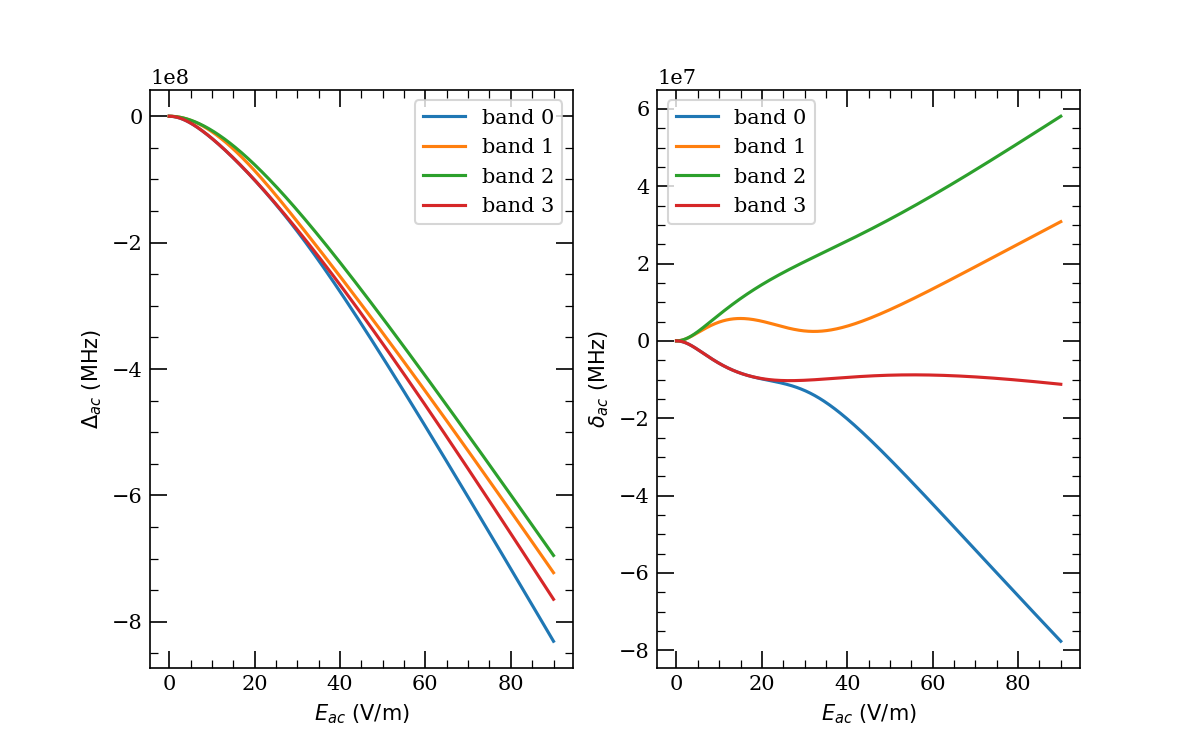

In [94]:
fig,axar = plt.subplots(1,2,figsize=(8,5))
c = 0
dac = np.zeros((len(t_inds),len(varied[1])))
ax = axar[0]
for ind in t_inds:
    rind = ind+comp["n_max"]*len(basis)
    dac[c] = energies[rind]-energies[rind,0]
    ax.plot(varied[1],dac[c]/tau,label=f"band {c}")
    c += 1
#axar[0].plot(varied[1],dac.mean(0),label="CoG")
ax.legend()
ax.set_xlabel("$E_{ac}~\\rm(V/m)$")
ax.set_ylabel("$\Delta_{ac}~\\rm (MHz)$")

ax = axar[1]
for i,ind in enumerate(t_inds):
    rind = ind+comp["n_max"]*len(basis)
    ax.plot(varied[1],(dac[i]-dac.mean(0))/tau,label=f"band {i}")

ax.legend()
ax.set_xlabel("$E_{ac}~\\rm(V/m)$")
ax.set_ylabel("$\delta_{ac}~\\rm (MHz)$")
fig.show()

# Save the data

In [95]:
fname = f"{comp_name}_energies_eac.npy"
if not os.path.isdir(convergence_tests_dir):
    os.mkdir(convergence_tests_dir)
np.save(os.path.join(convergence_tests_dir,fname), energies)

# Scan Edc

In [96]:
# set scan params
varied = ("Edc",Edc_list)
fields_p = {key: value for key, value in fields.items()}
fields_p[varied[0]] = varied[1]

#old_scans = eigen_find(t_level,comp, fields_p)
#loading = False
# TODO : this is broken rn. Implement eigen_terpolate then fix this.
#if loading and len(old_scans) > 0: 
#    energies = np.load(old_scans[0][0].format("energies"))
#    eigenstates = np.load(old_scans[0][0].format("eigenstates"))
#else:
zeeman_offset=1e6
H0 = build_H0(basis, t_level, offset_zeeman=zeeman_offset)
if scheme == "red":
    H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 3]
f_jsplit = 3e6
jsplit = True
if jsplit:
    for ind, j in f_inds:
        H0[ind,ind] += f_jsplit*j
    
energies, eigenstates, error = floquet_loop(
    basis,
    H0,
    n_max=comp["n_max"],
    varied=varied,
    energy_bands=True,
    **fields
)

#f_name = f"convergenceTest-nmax={n_max}-dw={max_det}-dl={dl}-{{}}"
#filepath = "Shirley-Floquet_results\\convergence_tests"
#np.save(os.path.join(filepath,f_name.format("energies")), energies)
#np.save(os.path.join(filepath,f_name.format("eigenstates")), eigenstates)
#eigen_save(t_level, comp, fields_p, energies, eigenstates)

336
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008963823318481445
Hdc built in 0.0008311271667480469
Hfloquet put together in 0.001039266586303711
Floquet matrix built after 0.010834217071533203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.30267882347106934s
Normalization Complete after 0.003510713577270508 s
floquet_diag call completed in 0.31702375411987305s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-3>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.6060606060606061, theta 0
Diagonalized after time: 0.30509471893310547s
Normalization Complete after 0.004503011703491211 s
floquet_diag call completed in 0.3216230869293213s
Diagonalization complete for independent variable entry, value 4, 0.6060606060606061
re-arrangement done after time 0.010006904602050781s
little_d built in 0.008514404296875
Hdc built in 0.0015091896057128906
Hfloquet put together in 0.0009992122650146484
Floquet matrix built after 0.012031793594360352 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.7575757575757576, theta 0
Diagonalized after time: 0.3090054988861084s
Normalization Complete after 0.004000663757324219 s
floquet_diag call completed in 0.326038122177124s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 2.5757575757575757, theta 0
Diagonalized after time: 0.3245515823364258s
Normalization Complete after 0.0035822391510009766 s
floquet_diag call completed in 0.34009790420532227s
Diagonalization complete for independent variable entry, value 17, 2.5757575757575757
re-arrangement done after time 0.009000539779663086s
little_d built in 0.009563446044921875
Hdc built in 0.0011258125305175781
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.011686325073242188 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 2.7272727272727275, theta 0
Diagonalized after time: 0.31416964530944824s
Normalization Complete after 0.003499746322631836 s
floquet_diag call completed in 0.32935571670532227s
Diagonalization complete for independe

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 4.545454545454546, theta 0
Diagonalized after time: 0.3339965343475342s
Normalization Complete after 0.003999233245849609 s
floquet_diag call completed in 0.35000085830688477s
Diagonalization complete for independent variable entry, value 30, 4.545454545454546
re-arrangement done after time 0.008997678756713867s
little_d built in 0.009000062942504883
Hdc built in 0.0010030269622802734
Hfloquet put together in 0.0009970664978027344
Floquet matrix built after 0.01100015640258789 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 4.696969696969697, theta 0
Diagonalized after time: 0.34321045875549316s
Normalization Complete after 0.004000186920166016 s
floquet_diag call completed in 0.3602163791656494s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 6.515151515151516, theta 0
Diagonalized after time: 0.3116016387939453s
Normalization Complete after 0.003513813018798828 s
floquet_diag call completed in 0.32562685012817383s
Diagonalization complete for independent variable entry, value 43, 6.515151515151516
re-arrangement done after time 0.009000778198242188s
little_d built in 0.009544610977172852
Hdc built in 0.0010361671447753906
Hfloquet put together in 0.001005411148071289
Floquet matrix built after 0.011586189270019531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 6.666666666666667, theta 0
Diagonalized after time: 0.33721184730529785s
Normalization Complete after 0.0030634403228759766 s
floquet_diag call completed in 0.35286426544189453s
Diagonalization complete for independent v

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 8.484848484848484, theta 0
Diagonalized after time: 0.3201487064361572s
Normalization Complete after 0.0029985904693603516 s
floquet_diag call completed in 0.33530306816101074s
Diagonalization complete for independent variable entry, value 56, 8.484848484848484
re-arrangement done after time 0.009049177169799805s
little_d built in 0.009509563446044922
Hdc built in 0.0015673637390136719
Hfloquet put together in 0.0009479522705078125
Floquet matrix built after 0.012024879455566406 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 8.636363636363637, theta 0
Diagonalized after time: 0.32655787467956543s
Normalization Complete after 0.0035037994384765625 s
floquet_diag call completed in 0.34308695793151855s
Diagonalization complete for independent

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 10.454545454545455, theta 0
Diagonalized after time: 0.31288766860961914s
Normalization Complete after 0.0029985904693603516 s
floquet_diag call completed in 0.3283426761627197s
Diagonalization complete for independent variable entry, value 69, 10.454545454545455
re-arrangement done after time 0.008518457412719727s
little_d built in 0.008518218994140625
Hdc built in 0.001001596450805664
Hfloquet put together in 0.0009989738464355469
Floquet matrix built after 0.010518789291381836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 10.606060606060606, theta 0
Diagonalized after time: 0.31169915199279785s
Normalization Complete after 0.004405021667480469 s
floquet_diag call completed in 0.32662296295166016s
Diagonalization complete for independen

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 12.424242424242424, theta 0
Diagonalized after time: 0.31625890731811523s
Normalization Complete after 0.004005908966064453 s
floquet_diag call completed in 0.331784725189209s
Diagonalization complete for independent variable entry, value 82, 12.424242424242424
re-arrangement done after time 0.008519887924194336s
little_d built in 0.009507179260253906
Hdc built in 0.0010013580322265625
Hfloquet put together in 0.0009992122650146484
Floquet matrix built after 0.011507749557495117 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 12.575757575757576, theta 0
Diagonalized after time: 0.3100724220275879s
Normalization Complete after 0.004506587982177734 s
floquet_diag call completed in 0.32608675956726074s
Diagonalization complete for independent 

Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 14.393939393939394, theta 0
Diagonalized after time: 0.3115081787109375s
Normalization Complete after 0.004000663757324219 s
floquet_diag call completed in 0.32800936698913574s
Diagonalization complete for independent variable entry, value 95, 14.393939393939394
re-arrangement done after time 0.009513139724731445s
little_d built in 0.009511947631835938
Hdc built in 0.0010023117065429688
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.011512279510498047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (336, 336)
AC parameters Eac 89.6, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 14.545454545454547, theta 0
Diagonalized after time: 0.30836057662963867s
Normalization Complete after 0.004503726959228516 s
floquet_diag call completed in 0.32437658309936523s
Diagonalization complete for independen

<IPython.core.display.Javascript object>


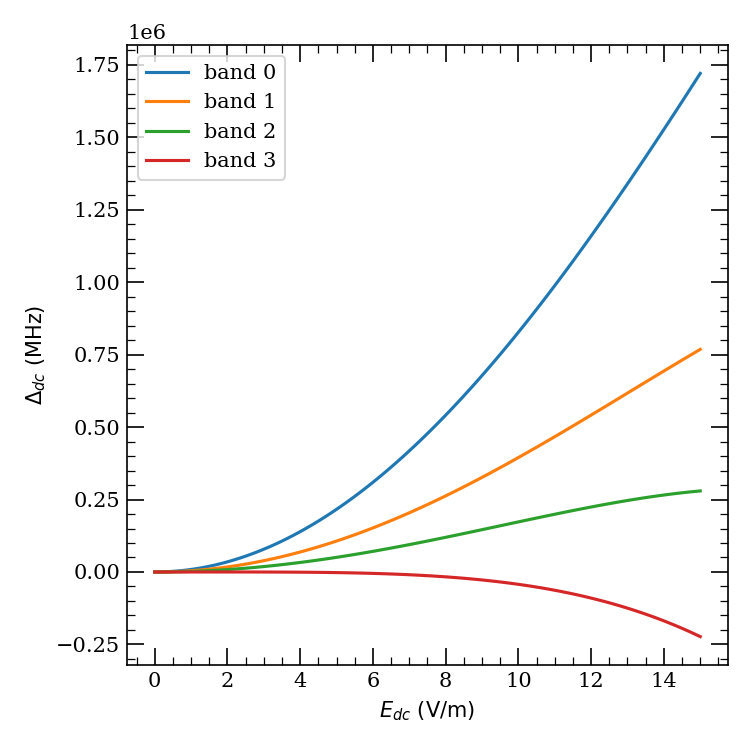

In [97]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
c = 0
dac = np.zeros((len(t_inds),len(varied[1])))
for ind in t_inds:
    rind = ind+comp["n_max"]*len(basis)
    dac[c] = energies[rind]-energies[rind,0]
    ax.plot(varied[1],dac[c]/tau,label=f"band {c}")
    c += 1
#axar[0].plot(varied[1],dac.mean(0),label="CoG")
ax.legend()
ax.set_xlabel("$E_{dc}~\\rm(V/m)$")
ax.set_ylabel("$\Delta_{dc}~\\rm (MHz)$")
fig.tight_layout()
fig.show()

In [98]:
fname = f"{comp_name}_energies_edc.npy"
if not os.path.isdir(convergence_tests_dir):
    os.mkdir(convergence_tests_dir)
np.save(os.path.join(convergence_tests_dir,fname), energies)

In [5]:
comp_names = list(comp_settings_list.keys())
comp_eac_results = {}
comp_edc_results = {}

for name in comp_names:
    eac_name = f"{name}_energies_eac.npy"
    energies = np.load(os.path.join(convergence_tests_dir,eac_name))
    t_inds_fname = f"tinds_{name}.py.npy"
    t_inds = np.load(os.path.join(convergence_tests_dir,f"tinds_{name}.npy"))
    dacs = np.zeros((len(t_inds),energies.shape[1]))
    print(t_inds)
    for i,ind in enumerate(t_inds):
        dim = len(energies)//(2*comp_settings_list[name]['n_max']+1)
        #print(f"n_max = {comp_settings_list[name]['n_max']}\ndim={dim}")
        rind = ind + comp_settings_list[name]["n_max"]*dim
        print(rind)
        dacs[i] = energies[rind] - energies[rind,0]
        print(f"name:{name}; dim:{dim}")
    
    comp_eac_results[name] = dacs
    
    edc_name = f"{name}_energies_edc.npy"
    energies = np.load(os.path.join(convergence_tests_dir,edc_name))
    ddcs = np.zeros((len(t_inds),energies.shape[1]))
    for i, ind in enumerate(t_inds):
        dim = len(energies)//(2*comp_settings_list[name]['n_max']+1)
        rind = ind + comp_settings_list[name]["n_max"]*dim
        ddcs[i] = energies[rind] - energies[rind,0]
    
    comp_edc_results[name] = ddcs

[18 19 20 21]
114
name:default; dim:48
115
name:default; dim:48
116
name:default; dim:48
117
name:default; dim:48
[4 5 6 7]
44
name:dipoles; dim:20
45
name:dipoles; dim:20
46
name:dipoles; dim:20
47
name:dipoles; dim:20
[34 35 36 37]
194
name:more_energy; dim:80
195
name:more_energy; dim:80
196
name:more_energy; dim:80
197
name:more_energy; dim:80
[18 19 20 21]
162
name:more_photons; dim:48
163
name:more_photons; dim:48
164
name:more_photons; dim:48
165
name:more_photons; dim:48


<IPython.core.display.Javascript object>


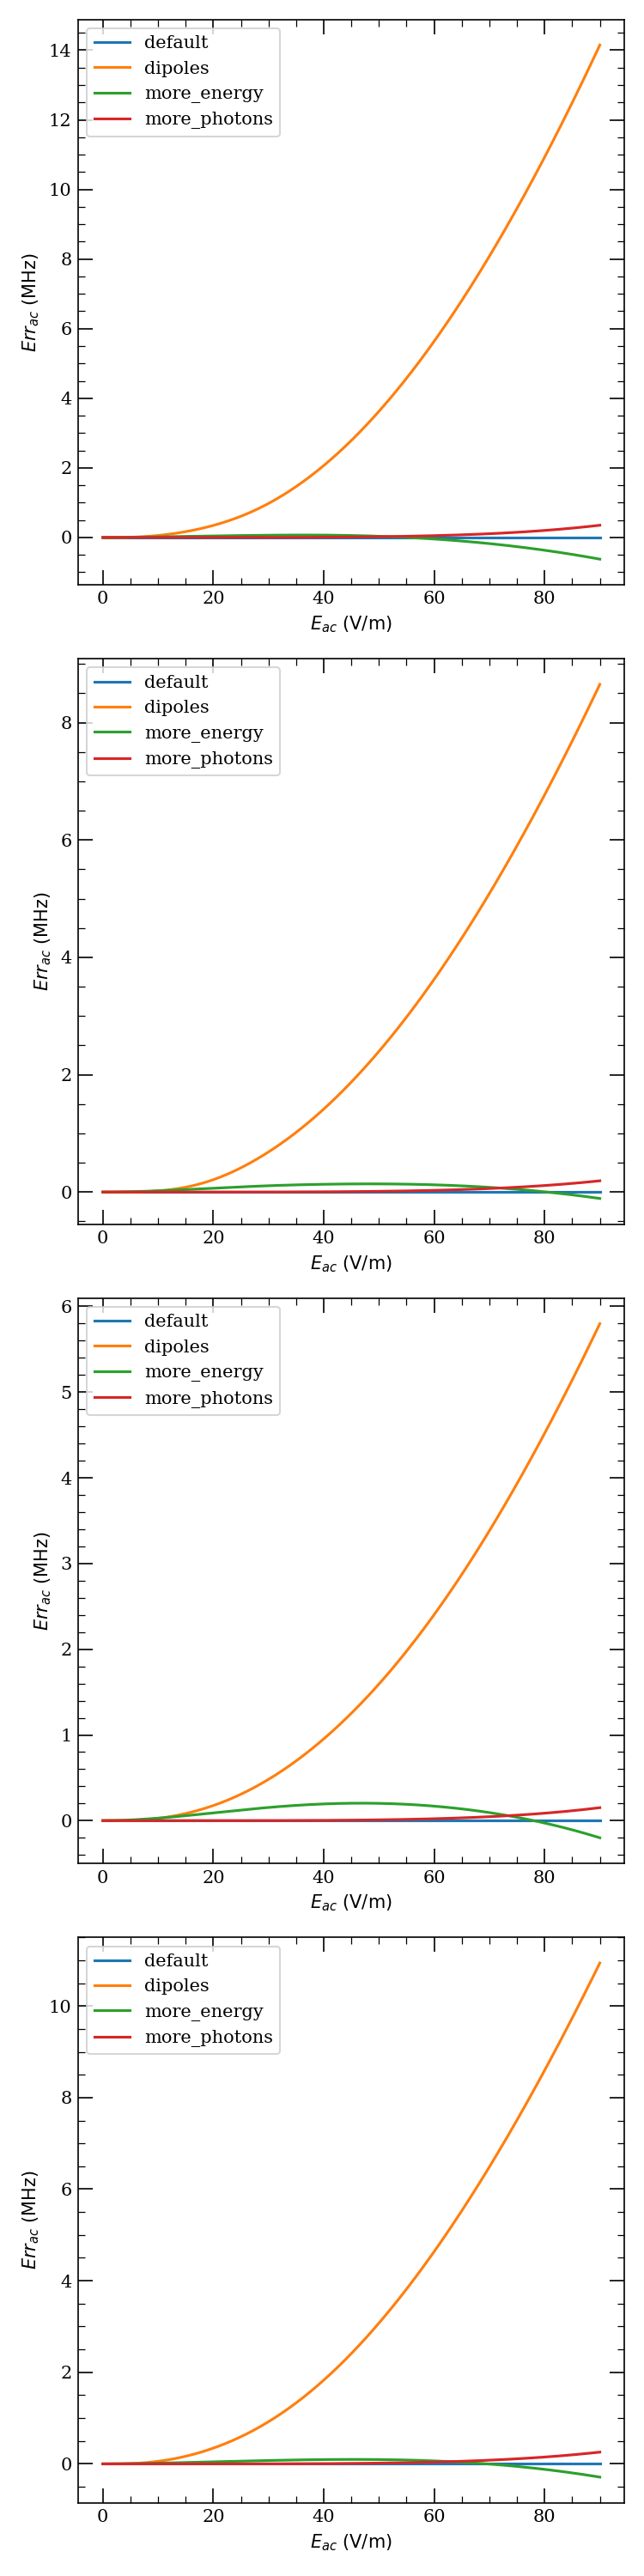

In [6]:
fig,axar = plt.subplots(len(t_inds),1,figsize=(5,5*len(t_inds)))

default = comp_eac_results["default"]

for name, dacs in comp_eac_results.items():
    for i, dac in enumerate(dacs):
        ax = axar[i]
        ax.plot(Eac_list, (dac-default[i])/tau*1e-6, label=name)
        
for ax in axar:
    ax.legend()
    ax.set_xlabel("$E_{ac}~\\rm (V/m)$")
    ax.set_ylabel("$Err_{ac}~\\rm (MHz)$")
fig.tight_layout()
fig.show()
        

<IPython.core.display.Javascript object>


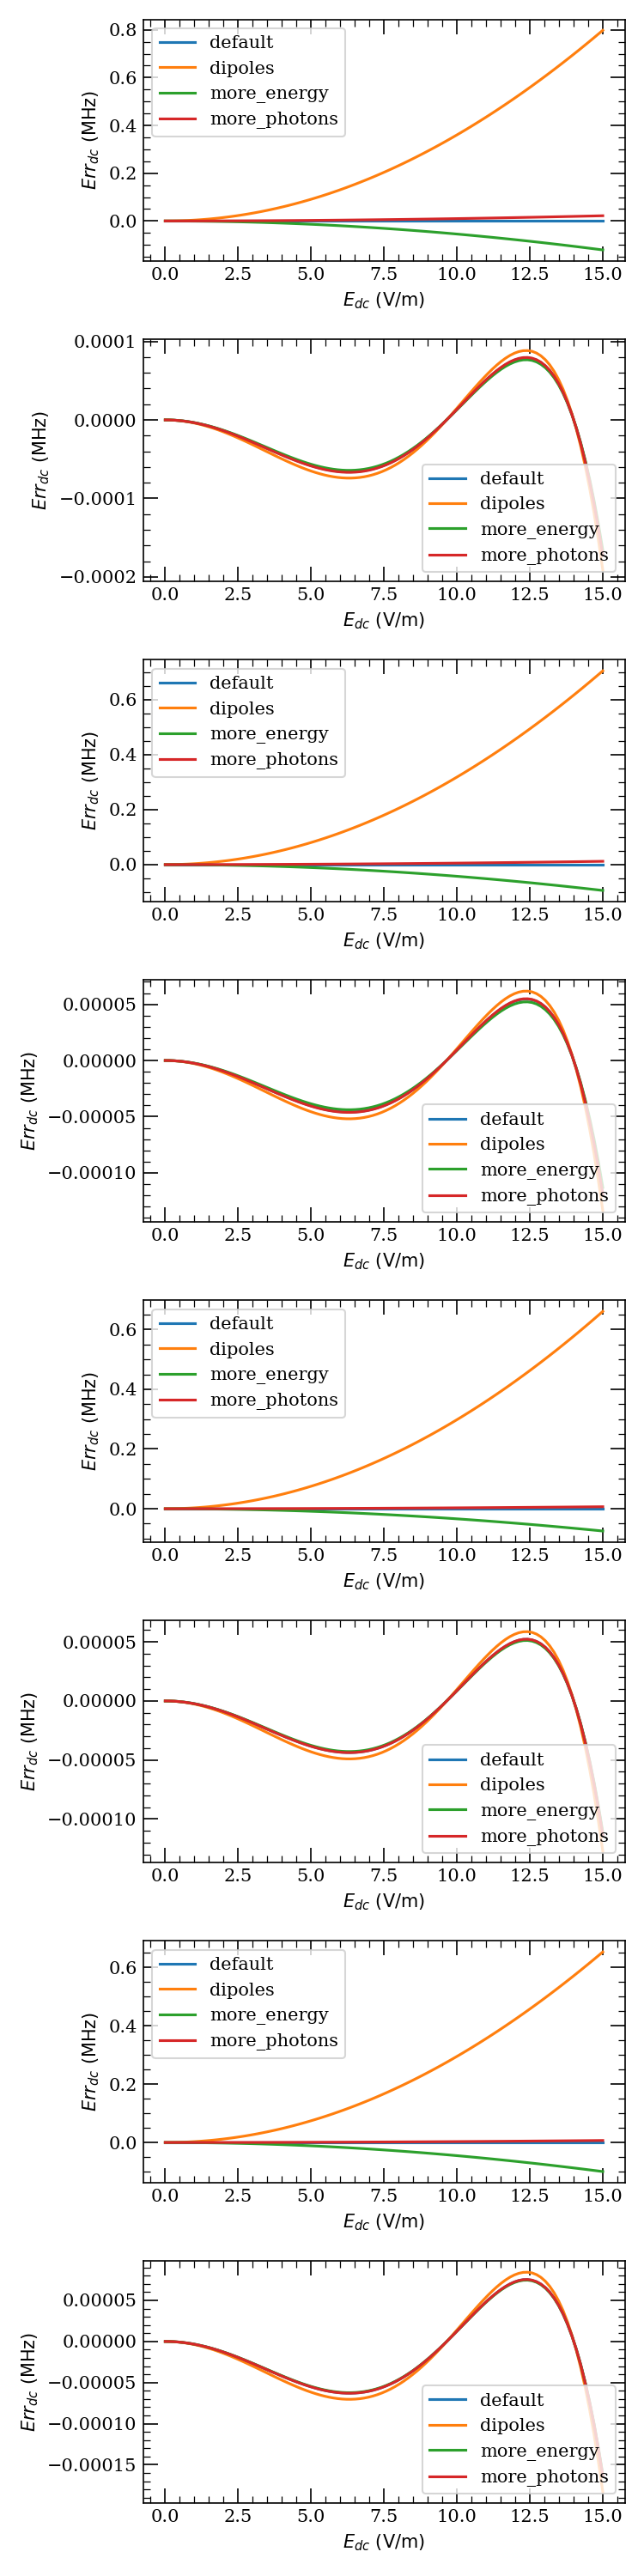

settings: default

	band 0:
		alpha: -173.3662344615776MHz/(V/cm)^2
		beta: 120.00007591891348Hz/(V/m)^4

	band 1:
		alpha: -86.39549871037215MHz/(V/cm)^2
		beta: 102.5563783355213Hz/(V/m)^4

	band 2:
		alpha: -41.721506225724234MHz/(V/cm)^2
		beta: 93.23230901336859Hz/(V/m)^4

	band 3:
		alpha: 0.07115618093116018MHz/(V/cm)^2
		beta: 108.5989099786097Hz/(V/m)^4
settings: dipoles

	band 0:
		alpha: -246.31265094852787MHz/(V/cm)^2
		beta: 130.8319845668558Hz/(V/m)^4

	band 1:
		alpha: -150.83123173132586MHz/(V/cm)^2
		beta: 112.51359950114153Hz/(V/m)^4

	band 2:
		alpha: -102.0634186135528MHz/(V/cm)^2
		beta: 101.90282004243636Hz/(V/m)^4

	band 3:
		alpha: -59.682894730393386MHz/(V/cm)^2
		beta: 117.9479082803381Hz/(V/m)^4
settings: more_energy

	band 0:
		alpha: -162.28643929445536MHz/(V/cm)^2
		beta: 118.32645079786911Hz/(V/m)^4

	band 1:
		alpha: -77.79952354543376MHz/(V/cm)^2
		beta: 101.26505331997737Hz/(V/m)^4

	band 2:
		alpha: -34.84149623307059MHz/(V/cm)^2
		beta: 91.9140378188

In [7]:
fig,axar = plt.subplots(len(t_inds)*2,1,figsize=(5,5*len(t_inds)))

default = comp_edc_results["default"]

alphas = np.zeros((len(comp_names),4))
betas = np.zeros(alphas.shape)
func = lambda x, alpha, beta: -0.5*alpha*x**2-(beta*x**4)/factorial(4)

c=0
for name, ddcs in comp_edc_results.items():
    print(f"settings: {name}")
    for i, ddc in enumerate(ddcs):
        ax = axar[2*i]
        ax.plot(Edc_list, (ddc-default[i])/tau*1e-6, label=name)

        guess = [-2*ddc[-1]/Edc_list[-1], 0]
        
        popt,pcov = curve_fit(func,Edc_list,ddc, p0=guess)
        perr = np.sqrt(np.diag(pcov))
        
        alphas[c,i],betas[c,i] = popt[0],popt[1]
        print(f"\n\tband {i}:\n\t\talpha: {alphas[c,i]*1e-2/tau}MHz/(V/cm)^2\n\t\tbeta: {betas[c,i]/tau}Hz/(V/m)^4")
        
        #ax.plot(Edc_list, (func(Edc_list,*popt)-0*default[i])/tau*1e-6, label=f"fit {name}")
        
        res = func(Edc_list,*popt)-ddc
        
        ax = axar[2*i+1]
        
        ax.plot(Edc_list,res*1e-6/tau,label=name)
    c += 1
for ax in axar:
    ax.legend()
    ax.set_xlabel("$E_{dc}~\\rm (V/m)$")
    ax.set_ylabel("$Err_{dc}~\\rm (MHz)$")
fig.tight_layout()
fig.show()
        

<IPython.core.display.Javascript object>


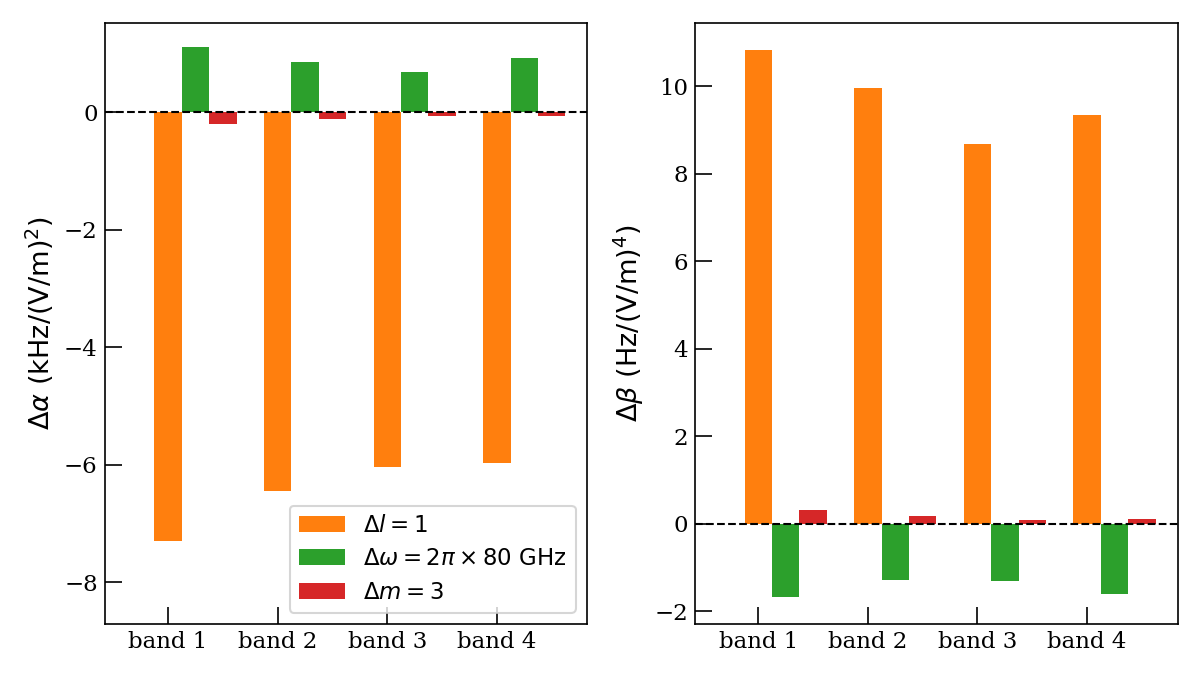

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
x = np.arange(len(comp_names))  # the label locations
display_names = ["", "$\Delta l = 1$", "$\Delta \omega =2\pi\\times 80 ~\\rm GHz$", "$\Delta m = 3$"]
width = 0.25  # the width of the bars

fig, axar = plt.subplots(1,2,figsize=(8,4.5))

ax = axar[0]
for c, name in enumerate(comp_names):
    offset = width * c
    label = display_names[c]
    rects = ax.bar(x + offset, (alphas[c]-alphas[0])/tau*1e-3, width, label=label)
    #ax.bar_label(rects, padding=3)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\Delta\\alpha ~\\rm(kHz/(V/m)^2)$')
#ax.set_title('Penguin attributes by species')
#ax.vlines(x,*ax.get_ylim())
ax.set_xticks(x + width)
ax.set_xticklabels([f"band {i}" for i in [1,2,3,4]],fontdict={"fontsize": 12})
ax.tick_params(axis = 'both', labelsize=11,top=False,right=False)
ax.axhline(0,c="black",linewidth=1,ls="--")
ax.legend(loc='lower right',fontsize=11)
ax.set_ylim(ax.get_ylim()[0]-1,ax.get_ylim()[1])
#ax.set_yscale("symlog")
ax.minorticks_off()

ax = axar[1]
for c, name in enumerate(comp_names):
    offset = width * c
    label = display_names[c]
    rects = ax.bar(x + offset, (betas[c]-betas[0])/tau, width, label=label)
    #ax.bar_label(rects, padding=3)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\Delta\\beta ~\\rm(Hz/(V/m)^4)$')
#ax.set_title('Penguin attributes by species')
#ax.vlines(x,*ax.get_ylim())
ax.set_xticks(x + width)
ax.set_xticklabels([f"band {i}" for i in [1,2,3,4]],fontdict={"fontsize": 12})
ax.tick_params(axis = 'both', labelsize=11,top=False,right=False)
ax.axhline(0,c="black",linewidth=1,ls="--")
#ax.legend(loc='lower right',fontsize=11)
#ax.set_yscale("symlog")
ax.minorticks_off()

for ax in axar:
    for txt in [ax.xaxis.label,ax.yaxis.label]:
        txt.set_fontsize(13)
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(convergence_tests_dir,"convergence.png"))
fig.savefig(os.path.join(convergence_tests_dir,"convergence.eps"))
#fig.savefig(os.path.join(zfigs_dir,"convergence.png"))

<IPython.core.display.Javascript object>


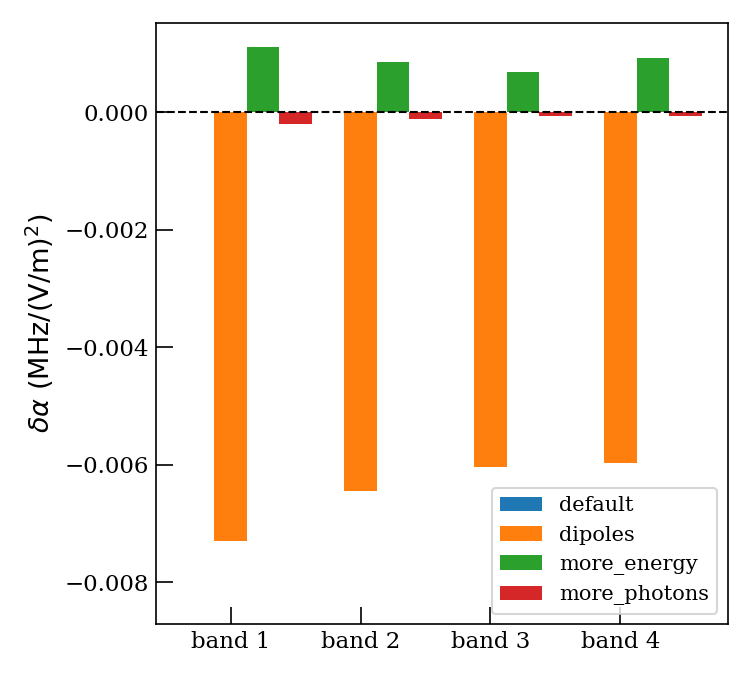

In [9]:
x = np.arange(len(comp_names))  # the label locations
display_names = ["text", "$\Delta l = 1$",]
width = 0.25  # the width of the bars

fig, ax = plt.subplots(1,1,figsize=(5,4.5))

for c, name in enumerate(comp_names):
    offset = width * c
    rects = ax.bar(x + offset, (alphas[c]-alphas[0])/tau*1e-6, width, label=name)
    #ax.bar_label(rects, padding=3)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\delta\\alpha ~\\rm(MHz/(V/m)^2)$')
#ax.set_title('Penguin attributes by species')
#ax.vlines(x,*ax.get_ylim())
ax.set_xticks(x + width)
ax.set_xticklabels([f"band {i}" for i in [1,2,3,4]],fontdict={"fontsize": 12})
ax.tick_params(axis = 'both', labelsize=11,top=False,right=False)
ax.axhline(0,c="black",linewidth=1,ls="--")
ax.legend(loc='lower right')
ax.set_ylim(ax.get_ylim()[0]-0.001,ax.get_ylim()[1])
#ax.set_yscale("symlog")
ax.minorticks_off()

for txt in [ax.xaxis.label,ax.yaxis.label]:
    txt.set_fontsize(13)
fig.tight_layout()
fig.show()
#fig.savefig(os.path.join(convergence_tests_dir,"alphas_convergence.png"))

In [11]:
print(convergence_tests_dir)

Shirley-Floquet_results/convergence_tests/


In [49]:
alphas[3]

array([-110191.2939652 ,  -54971.37097995,  -26598.13691999,
          -352.59909105])